In [4]:
"""
cybersecurity_ids.py
Option B + Feature Set A (Light & Interpretable)
- Stage 1: Binary (BENIGN vs ATTACK)
"""

import os, warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# -------------------------
# CONFIG
# -------------------------
CSV_PATH = "cic_ids2017_cleaned.csv"
MODELS_DIR = "Models"
RANDOM_STATE = 42
SAMPLE_FOR_DEV = False
SAMPLE_SIZE = 100000

os.makedirs(MODELS_DIR, exist_ok=True)

# -------------------------
# Load Data
# -------------------------
df = pd.read_csv(CSV_PATH, parse_dates=['timestamp'], infer_datetime_format=True)
print("Rows loaded:", len(df))

# Optional sample for dev
if SAMPLE_FOR_DEV:
    df = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=RANDOM_STATE).reset_index(drop=True)
    print("Sampled rows:", len(df))

# -------------------------
# Select Features (Light & Interpretable)
# -------------------------
features = [
    'Flow Duration',
    'Total Fwd Packets',
    'Total Backward Packets',
    'Total Length of Fwd Packets',
    'Total Length of Bwd Packets',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Fwd IAT Mean',
    'Bwd IAT Mean'
]

# Clean inf / NaN
df[features] = df[features].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=features)

# Add engineered features
df['ratio_fwd_bwd_pkts'] = (df['Total Fwd Packets'] / df['Total Backward Packets'].replace({0: np.nan})).fillna(0)
df['bytes_per_fwd_pkt'] = (df['Total Length of Fwd Packets'] / df['Total Fwd Packets'].replace({0: np.nan})).fillna(0)
features += ['ratio_fwd_bwd_pkts', 'bytes_per_fwd_pkt']

print("Final features:", features)

# -------------------------
# Stage 1: Binary classifier
# -------------------------
df_stage1 = df.copy()
df_stage1['is_attack_binary'] = (df_stage1['attack_type'] != 'BENIGN').astype(int)

X = df_stage1[features].astype(float)
y = df_stage1['is_attack_binary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("Stage1 train/test sizes:", X_train.shape, X_test.shape)

pipeline_stage1 = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1))
])

pipeline_stage1.fit(X_train, y_train)
print("Stage 1 trained.")

# Evaluate Stage 1
y_pred = pipeline_stage1.predict(X_test)
print("Stage 1 classification report (BENIGN vs ATTACK):")
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score

# Calculate exact metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Exact Accuracy:  {accuracy:.6f} ({accuracy*100:.4f}%)")
print(f"Exact Precision: {precision:.6f}")
print(f"Exact Recall:    {recall:.6f}")
print(f"Exact F1-score:    {f1:.6f}")

# Or get the full classification report without rounding
report_dict = classification_report(y_test, y_pred, target_names=['BENIGN','ATTACK'], output_dict=True)
print("\nFull precision values:")
print(f"BENIGN precision: {report_dict['BENIGN']['precision']:.6f}")
print(f"ATTACK precision: {report_dict['ATTACK']['precision']:.6f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(pipeline_stage1, os.path.join(MODELS_DIR, "stage1_binary_pipeline_A.joblib"))



Rows loaded: 225741
Final features: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Flow Bytes/s', 'Flow Packets/s', 'Fwd IAT Mean', 'Bwd IAT Mean', 'ratio_fwd_bwd_pkts', 'bytes_per_fwd_pkt']
Stage1 train/test sizes: (180568, 11) (45143, 11)
Stage 1 trained.
Stage 1 classification report (BENIGN vs ATTACK):
Exact Accuracy:  0.999557 (99.9557%)
Exact Precision: 0.999727
Exact Recall:    0.999492
Exact F1-score:    0.999609

Full precision values:
BENIGN precision: 0.999335
ATTACK precision: 0.999727
Confusion matrix:
 [[19531     7]
 [   13 25592]]


['Models/stage1_binary_pipeline_A.joblib']

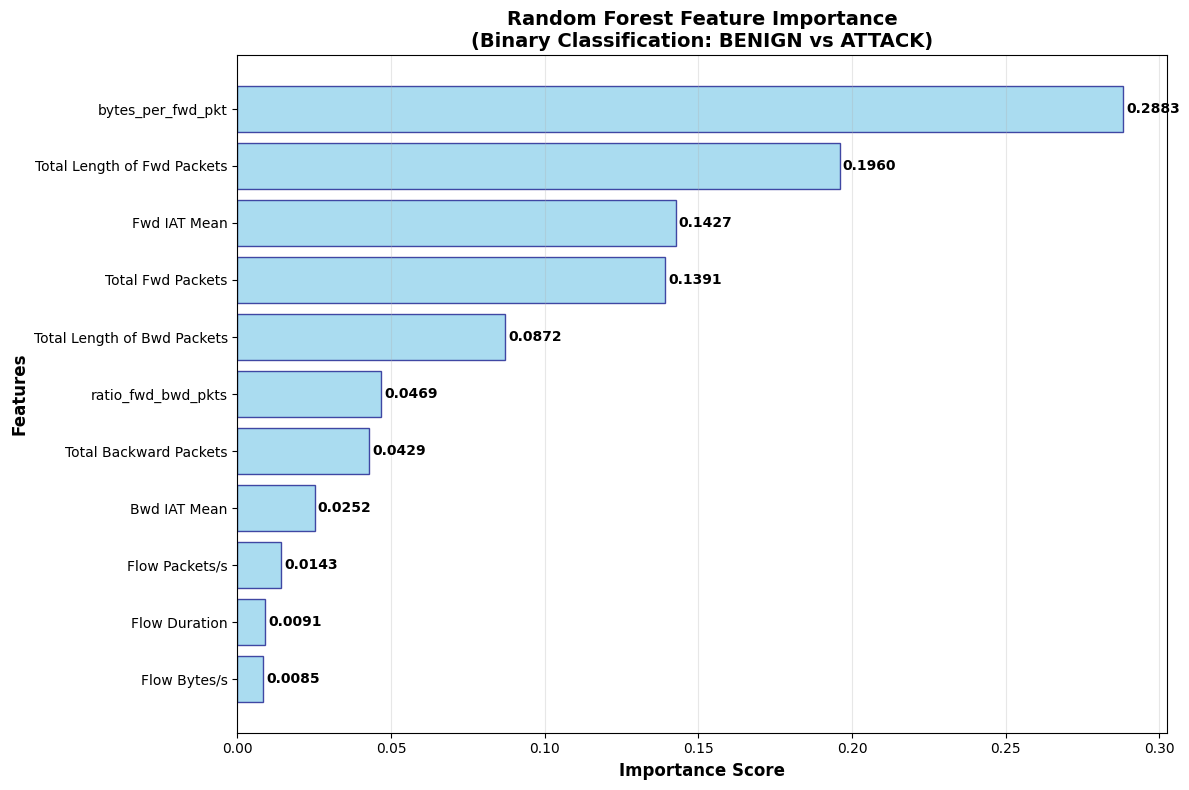


FEATURE IMPORTANCE ANALYSIS
Total features: 11
Most important feature: bytes_per_fwd_pkt (0.2883)
Least important feature: Flow Bytes/s (0.0085)
Average importance: 0.0909

Top 5 Most Important Features:
  bytes_per_fwd_pkt: 0.2883
  Total Length of Fwd Packets: 0.1960
  Fwd IAT Mean: 0.1427
  Total Fwd Packets: 0.1391
  Total Length of Bwd Packets: 0.0872


In [5]:
# -------------------------
# Enhanced Feature Importance Visualization
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Get feature importance
feature_importance = pipeline_stage1.named_steps['clf'].feature_importances_

# Create DataFrame and sort
fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

# Create plot
plt.figure(figsize=(12, 8))
bars = plt.barh(fi_df['Feature'], fi_df['Importance'],
                color='skyblue', edgecolor='navy', alpha=0.7)

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', ha='left', va='center', fontweight='bold')

# Customize plot
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Random Forest Feature Importance\n(Binary Classification: BENIGN vs ATTACK)',
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(MODELS_DIR, "feature_importance_stage1.png"),
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print summary statistics
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)
print(f"Total features: {len(features)}")
print(f"Most important feature: {fi_df.iloc[-1]['Feature']} ({fi_df.iloc[-1]['Importance']:.4f})")
print(f"Least important feature: {fi_df.iloc[0]['Feature']} ({fi_df.iloc[0]['Importance']:.4f})")
print(f"Average importance: {fi_df['Importance'].mean():.4f}")

# Show top 5 features
print("\nTop 5 Most Important Features:")
for i, row in fi_df.tail(5).iloc[::-1].iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")